In [9]:
import io
import itertools

from PIL import Image
from pyqupath import buffer
from pyqupath.utils import load_geojson_to_gdf

# 01. Merge open polylines

In [10]:
# load geojson file
gdf = load_geojson_to_gdf(geojson_path="demo/TMA552.1_Fusion + H&E.geojson")
gdf_polygons = gdf[gdf.geometry.geom_type == "Polygon"][["geometry"]]
gdf_lines = gdf[gdf.geometry.geom_type == "LineString"][["geometry"]]

# set parameters
buffer_distance = 200

limit_expand = 0.1
xmin = gdf.geometry.bounds.minx.min()
xmax = gdf.geometry.bounds.maxx.max()
ymin = gdf.geometry.bounds.miny.min()
ymax = gdf.geometry.bounds.maxy.max()
xlim = tuple(
    (xmax + xmin) / 2 + sep * (1 + limit_expand) * (xmax - xmin) / 2 for sep in (-1, 1)
)
ylim = tuple(
    (ymax + ymin) / 2 + sep * (1 + limit_expand) * (ymax - ymin) / 2 for sep in (1, -1)
)

# iterate buffer merge
figs = [
    buffer.plot_lines_polygons(
        gdf_polygons,
        gdf_lines,
        buffer_distance=buffer_distance,
        xlim=xlim,
        ylim=ylim,
    )
]
lines_0 = set(gdf_lines.geometry)

idx = 1
while True:
    gdf_polygons, gdf_lines = buffer.merge_buffers(
        gdf_polygons, gdf_lines, buffer_distance
    )
    figs.append(
        buffer.plot_lines_polygons(
            gdf_polygons,
            gdf_lines,
            buffer_distance=buffer_distance,
            xlim=xlim,
            ylim=ylim,
        )
    )
    lines = set(gdf_lines.geometry)
    if len(lines) == 0 or lines_0 == lines:
        break
    lines_0 = lines

    print(f"iteration {idx}")
    idx += 1

print(f"{len(lines)} remaining lines")


iteration 1
iteration 2
iteration 3
iteration 4
0 remaining lines


/mnt/nfs/home/wenruiwu/projects/pyqupath/pyqupath/buffer.py:115: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  gdf_lines_buffers.beg_buffer.plot(ax=axes, color="red", alpha=0.2)
/mnt/nfs/home/wenruiwu/projects/pyqupath/pyqupath/buffer.py:116: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  gdf_lines_buffers.end_buffer.plot(ax=axes, color="blue", alpha=0.2)


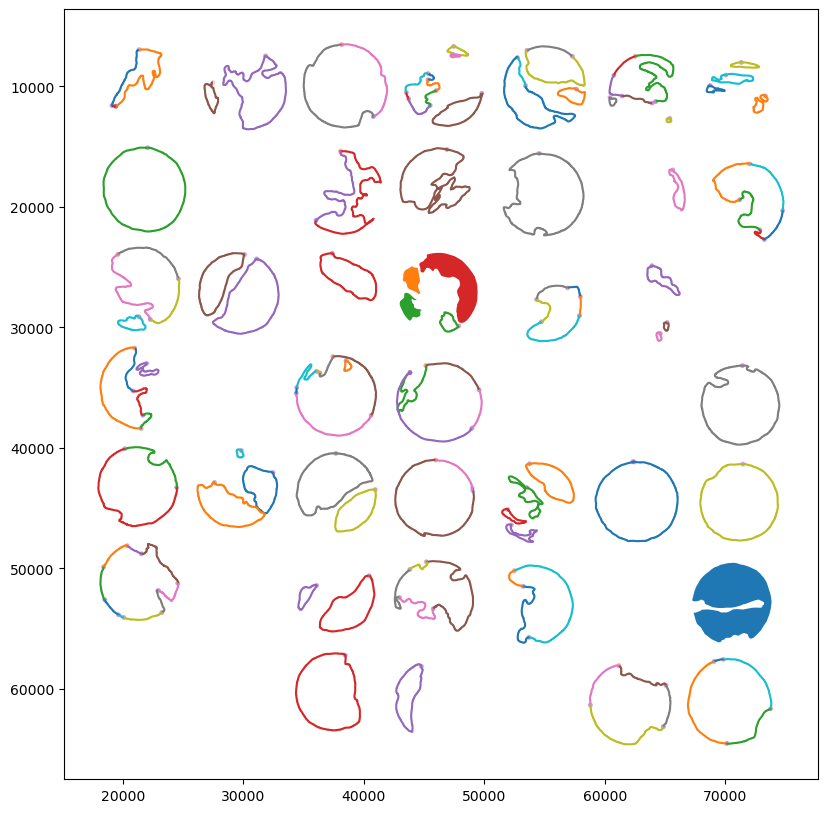

In [11]:
figs[0]

# 02. Remove small polygon within large polygon

In [12]:
index_rm = []
for i, j in list(itertools.combinations(gdf_polygons.index, 2)):
    i_geom = gdf_polygons.at[i, "geometry"].buffer(0)
    j_geom = gdf_polygons.at[j, "geometry"].buffer(0)

    if i_geom.contains(j_geom):
        gdf_polygons.at[i, "geometry"] = i_geom.difference(j_geom)
        index_rm.append(j)
        continue
    elif j_geom.contains(i_geom):
        gdf_polygons.at[j, "geometry"] = j_geom.difference(i_geom)
        index_rm.append(i)
        continue
gdf_polygons = gdf_polygons.drop(index=index_rm)
figs.append(
    buffer.plot_lines_polygons(
        gdf_polygons,
        gdf_lines,
        buffer_distance=buffer_distance,
        xlim=xlim,
        ylim=ylim,
    )
)

/mnt/nfs/home/wenruiwu/projects/pyqupath/pyqupath/buffer.py:115: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  gdf_lines_buffers.beg_buffer.plot(ax=axes, color="red", alpha=0.2)
/mnt/nfs/home/wenruiwu/projects/pyqupath/pyqupath/buffer.py:116: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  gdf_lines_buffers.end_buffer.plot(ax=axes, color="blue", alpha=0.2)


In [13]:
# Review remaining lines
if len(lines) > 0:
    gdf_lines.at[0, "geometry"].coords[0], gdf_lines.at[0, "geometry"].coords[-1]

# 03. Save figures as GIF

In [14]:
im_pil = []

for i, fig in enumerate(figs):
    # Save the figure to a BytesIO buffer
    buf = io.BytesIO()
    if i != (len(figs) - 1):
        fig.suptitle(f"Step {i + 1}")
    else:
        fig.suptitle("Remove Overlaps")
    fig.savefig(buf, format="png")
    buf.seek(0)
    # Convert buffer to PIL Image
    im_pil.append(Image.open(buf))

im_pil[0].save(
    "demo.gif",
    format="GIF",
    append_images=im_pil[1:],
    save_all=True,
    duration=500,
    loop=0,
)